In [173]:
import itertools
import numbers
import os.path
import pickle
import random

import numpy as np
from scipy.stats import entropy
import pandas as pd

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import logging
logging.basicConfig(level=logging.DEBUG, format='%(levelname)-8s [%(lineno)d] %(message)s')

DEBUG    [211] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Populating the interactive namespace from numpy and matplotlib


/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'entropy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [343]:
mazsola = pickle.load(open(
    '/mnt/permanent/Language/Hungarian/Dic/sass15-535k-igei-szerkezet/mazsola_adatbazis-1.0.pkl',
    mode='rb'))

# Describe

In [3]:
def column_entropy(name):
    vals = mazsola.groupby(name).size().values
    vals += [mazsola[name].isna().sum()]
    #logging.debug((name, vals))
    return entropy(vals)

In [4]:
%time names = sorted(mazsola.columns, key=column_entropy, reverse=True)

CPU times: user 8min 23s, sys: 1min 24s, total: 9min 48s
Wall time: 9min 48s


In [123]:
mazsola.sample()[names[:15]]

,NOM,ACC,INS,DAT,SUB,INE,SUP,DEL,ELA,ALL,ILL,ABL,ADE,után,FOR
522638,felbecsülhetetlen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
mazsola[names[:15]].describe()

,NOM,ACC,INS,DAT,SUB,INE,SUP,DEL,ELA,ALL,ILL,ABL,ADE,után,FOR
count,16724007,10908900,2139300,1714663,2097838,3030171,2024586,800642,633013,571568,802894,494922,318894,222024,205977
unique,382994,200337,97785,82058,81529,76808,51417,48231,45017,43833,38144,38098,27810,22711,22128
top,aki,NULL,ez,az,az,év,alapPOSS,az,ez,az,figyelem,az,mi,ez,eredményPOSS
freq,227679,2562438,70383,66588,170742,56966,80795,94319,27084,37204,25000,32224,22541,7472,7405


# PMI

In [334]:
def get_pmi(mazsola, debug_inex=248239):
    modes = ['NOM', 'stem', 'ACC']
    svo_count = mazsola.groupby(modes).size().reset_index(name='count_')
    logging.info('')
    marginal = {mode: svo_count.groupby(mode).sum() for mode in modes}
    marginal2 = {mode_pair: svo_count.groupby(list(mode_pair)).sum()
             for mode_pair in itertools.combinations(modes, 2)}
    log_total = np.log(svo_count.count_.sum())
    svo_count['log_count'] = svo_count.count_
    logging.info('')
    for mode in modes:
        svo_count = svo_count.join(marginal[mode], on=mode, rsuffix=mode)
    for mode_pair in itertools.combinations(modes, 2):
        svo_count = svo_count.join(marginal2[mode_pair], on=mode_pair, rsuffix=mode_pair)
    logging.info('Computing log probabilities..')
    for name in svo_count.columns[4:]:
        svo_count[name] = np.log2(svo_count[name]) - log_total
    svo_count['pmi'] = svo_count.log_count
    svo_count['iact_info'] = svo_count.log_count
    #logging.debug(svo_count.loc[debug_inex])
    for mode in modes:
        svo_count.pmi -= svo_count['count_{}'.format(mode)]
        svo_count.iact_info += svo_count['count_{}'.format(mode)]
        #logging.debug(svo_count.loc[debug_inex])
    for mode_pair in itertools.combinations(modes, 2):
        svo_count.iact_info -= svo_count['count_{}'.format(mode_pair)]
        #logging.debug(svo_count.loc[debug_inex])
    svo_count['salience'] = svo_count.pmi+svo_count.log_count
    return svo_count, log_total

In [344]:
%time svo_count, log_total = get_pmi(mazsola)

INFO     [4] 
INFO     [10] 
INFO     [15] Computing log probabilities..


CPU times: user 34.1 s, sys: 1.28 s, total: 35.3 s
Wall time: 35.4 s


In [361]:
df = svo_count[svo_count.count_>10]

In [362]:
df.sort_values('pmi', ascending=False).head()

,NOM,stem,ACC,count_,log_count,count_NOM,count_stem,count_ACC,"count_('NOM', 'stem')","count_('NOM', 'ACC')","count_('stem', 'ACC')",pmi,iact_info,salience
3185108,szolgáltatóPOSS,felszereltet,hőmennyiség--mérő,14,-11.723258,-9.775725,-9.443150,-11.723258,-11.723258,-11.723258,-11.723258,19.218875,-7.495617,7.495617
1185972,fajlagos,szerepeltet,hőmennyiségPOSS,14,-11.723258,-11.282685,-6.268518,-11.723258,-11.723258,-11.723258,-11.723258,17.551203,-5.827945,5.827945
2437491,mikrobusz,átszakít,védőkorlát,12,-11.945650,-10.038760,-8.453797,-10.830173,-11.945650,-11.945650,-11.830173,17.377080,-5.546907,5.431429
2545390,méret,idevár,előrendelés,12,-11.945650,-8.038760,-9.360688,-11.623722,-11.623722,-11.945650,-11.945650,17.077520,-5.453797,5.131869
1808089,jóváhagyó,határozat,célokmányPOSS,20,-11.208685,-8.930700,-10.401330,-8.697723,-10.886757,-9.647970,-11.138295,16.821068,-7.565416,5.612383


In [363]:
df.sort_values('salience', ascending=False).head()

,NOM,stem,ACC,count_,log_count,count_NOM,count_stem,count_ACC,"count_('NOM', 'stem')","count_('NOM', 'ACC')","count_('stem', 'ACC')",pmi,iact_info,salience
3185108,szolgáltatóPOSS,felszereltet,hőmennyiség--mérő,14,-11.723258,-9.775725,-9.443150,-11.723258,-11.723258,-11.723258,-11.723258,19.218875,-7.495617,7.495617
1185972,fajlagos,szerepeltet,hőmennyiségPOSS,14,-11.723258,-11.282685,-6.268518,-11.723258,-11.723258,-11.723258,-11.723258,17.551203,-5.827945,5.827945
61368,Bocsi,megun,nyomkodás,129,-8.519386,-7.915903,-6.247525,-8.519386,-8.519386,-8.519386,-8.519386,14.163428,-5.644042,5.644042
1808089,jóváhagyó,határozat,célokmányPOSS,20,-11.208685,-8.930700,-10.401330,-8.697723,-10.886757,-9.647970,-11.138295,16.821068,-7.565416,5.612383
2437491,mikrobusz,átszakít,védőkorlát,12,-11.945650,-10.038760,-8.453797,-10.830173,-11.945650,-11.945650,-11.830173,17.377080,-5.546907,5.431429


In [364]:
df.sort_values('iact_info', ascending=False).head()

,NOM,stem,ACC,count_,log_count,count_NOM,count_stem,count_ACC,"count_('NOM', 'stem')","count_('NOM', 'ACC')","count_('stem', 'ACC')",pmi,iact_info,salience
1731179,isten,kijelent,maga,11,-12.071181,-2.235561,-1.062116,-0.400485,-11.071181,-8.930700,-11.007051,-8.373019,15.239589,-20.444200
2909282,rendelkezésPOSS,tesz,hely,17,-11.443150,-5.689835,1.119177,-1.937922,-10.282685,-11.282685,-10.576417,-4.934569,14.190057,-16.377719
2154361,köteles,eljár,NULL,12,-11.945650,-2.753563,-7.129733,4.540702,-11.007051,-9.623722,-10.530613,-6.603055,13.873141,-18.548706
2732455,országgyűlés,kér,figyelem,14,-11.723258,-2.512587,-0.231369,-2.181746,-9.886757,-11.007051,-9.464524,-6.797556,13.709371,-18.520814
2080010,képviselőPOSS,van,címPOSS,12,-11.945650,-2.179536,-0.548109,-4.904904,-10.208685,-11.830173,-11.138295,-4.313101,13.598954,-16.258752


DEBUG    [507] locator: <matplotlib.colorbar._ColorbarLogLocator object at 0x7f35260f1b70>
DEBUG    [536] Using auto colorbar locator on colorbar
DEBUG    [537] locator: <matplotlib.colorbar._ColorbarLogLocator object at 0x7f35260f1b70>
DEBUG    [693] Setting pcolormesh


DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2157] vmin 3.0 vmax 7074.0
DEBUG    [2212] ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG    [2157] vmin 3.0 vmax 7074.0
DEBUG    [2212] ticklocs [0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0]
DEBUG    [2157] vmin 3.0 vmax 7074.0
DEBUG    [2212] ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG    [2157] vmin 3.0 vmax 7074.0
DEBUG    [2212] ticklocs [0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0,

DEBUG    [2157] vmin 3.0 vmax 7074.0
DEBUG    [2212] ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG    [2157] vmin 3.0 vmax 7074.0
DEBUG    [2212] ticklocs [0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0]
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2157] vmin 3.0 vmax 7074.0
DEBUG    [2212] ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG    [2157] vmin 3.0 vmax 7074.0
DEBUG    [2212] ticklocs [0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0,

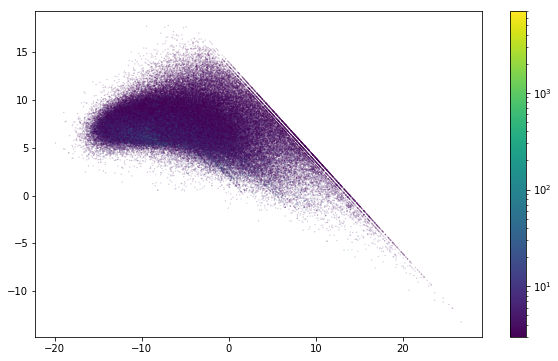

In [367]:
df = svo_count[svo_count.count_>2]
plt.scatter(df.pmi, df.iact_info, c=df.count_, s=.01, norm=matplotlib.colors.LogNorm())
plt.colorbar()